# Broad IBD Challenge Data and results visualizations

## Ideas

Data Exploration: Visualizing input data characteristics
    Spatial distribution of cells colored by region
    Spatial distribution of cells colored by quality score

Feature Extraction: Visualizing extracted image features
    PCA (Principal Component Analysis): Visualizing the principal components of image features
    t-SNE (t-Distributed Stochastic Neighbor Embedding): Visualizing local relationships between features
    UMAP (Uniform Manifold Approximation and Projection): Visualizing global and local structure of feature space

Model Performance: Visualizing model training and evaluation

Training Metrics
    Line plots of training and validation loss over epochs
    Line plots of Spearman correlation over epochs
    Learning rate schedules
    Gradient norms during training

Prediction Accuracy
    Scatter plots of predicted vs. actual expression values
    Histograms of prediction errors
    Box plots of prediction accuracy across genes
    Heatmaps of correlation matrices
    PCA plots comparing predictions to ground truth
    t-SNE plots comparing predictions to ground truth
    UMAP plots comparing predictions to ground truth

Gene Expression: Visualizing predicted gene expression patterns
    PCA of gene expression colored by region
    Gene expression distributions
    Gene-gene correlation heatmap
        Heatmaps of gene expression across cells
        Clustered heatmaps showing gene modules
        Heatmaps comparing predicted and actual expression
        Heatmaps showing expression differences between tissue regions

Spatial Patterns: Visualizing spatial distribution of gene expression
    Original H&E images showing tissue structure
    Overlay of cell positions on H&E images
    Zoomed-in views of specific tissue regions
    Scatter plots of cells colored by expression level
    Heatmaps overlaid on tissue images
    Contour plots showing expression gradients
    3D surface plots of expression landscapes

Differential Expression: Visualizing differences between tissue regions
    Histograms of gene expression values
    Box plots showing expression distribution across genes
    Violin plots comparing expression in different tissue regions
    Density plots of expression values
    Scatter plots of -log10(p-value) vs. log2(fold change)
    Highlighted points for significantly differentially expressed genes
    Labeled points for top genes

Comparison of dysplastic and non-dysplastic regions
    MA Plots
        Scatter plots of log2(fold change) vs. log2(mean expression)
        Highlighted points for significantly differentially expressed genes
        Smoothed trend lines showing overall patterns

## Input data

In [ ]:
 !ls data | grep ''

In [ ]:
name_data = 'UC1_I'

In [ ]:
data_directory_path = './data'

In [ ]:
import os
import spatialdata as sd 

In [ ]:
zarr_path = os.path.join(data_directory_path, f"{name_data}.zarr")
print("zarr_path", zarr_path, os.path.exists(zarr_path))
sdata = sd.read_zarr(zarr_path)


In [ ]:
sdata

In [ ]:
gene_name_list = sdata['anucleus'].var['gene_symbols'].values
gene_name_list[0:10], len(gene_name_list)

In [ ]:
size_subset = len(sdata['anucleus'].obs)
rows_to_keep = list(sdata['anucleus'].obs.sample(n=size_subset, random_state=42).index)
cell_id_train = sdata['anucleus'].obs["cell_id"].values

In [ ]:
dir_processed_dataset = 'resources/processed_dataset'

In [ ]:
patch_save_dir = os.path.join(dir_processed_dataset, "patches")
adata_save_dir = os.path.join(dir_processed_dataset, "adata")
splits_save_dir = os.path.join(dir_processed_dataset, "splits")

In [ ]:
# Path for the .h5 image dataset
h5_path = os.path.join(patch_save_dir, name_data + '.h5')

In [ ]:
sdata['anucleus'].obsm['spatial']

In [ ]:
[x for x in vars(sdata)]

In [ ]:
from extract_spatial_positions import extract_spatial_positions

In [ ]:
new_spatial_coord = extract_spatial_positions(sdata, cell_id_train)
# Store new spatial coordinates into sdata
sdata['anucleus'].obsm['spatial'] = new_spatial_coord

In [ ]:
df = sdata['anucleus'][0].to_df()

In [ ]:
df.loc[:, (df != 0).any(axis=0)].values

In [ ]:
    # Create the gene expression dataset (Y)
    print("Create gene expression dataset (Y) ...")
    y_subtracted = sdata['anucleus'][rows_to_keep].copy()

In [ ]:
    # Trick to set all index to same length to avoid problems when saving to h5
    y_subtracted.obs.index = ['x' + str(i).zfill(6) for i in y_subtracted.obs.index]

In [ ]:
y_subtracted

In [ ]:
os.path.join(adata_save_dir, f'{name_data}.h5ad')


In [ ]:
# Save the gene expression data to an H5AD file
y_subtracted.write(os.path.join(adata_save_ dir, f'{name_data}.h5ad'))

In [ ]:
for index in y_subtracted.obs.index:
    if len(index) != len(y_subtracted.obs.index[0]):
        warnings.warn("indices of y_subtracted.obs should all have the same length to avoid problems when saving to h5", UserWarning)

In [ ]:
import numpy as np

In [ ]:
# Extract spatial coordinates and barcodes (cell IDs) for the patches
coords_center = y_subtracted.obsm['spatial']
barcodes = np.array(y_subtracted.obs.index)

In [ ]:
barcodes

## Bioinformatics Plots

In [16]:
%matplotlib inline

In [17]:
from generate_bioinformatics_plots import generate_bioinformatics_plots

In [18]:
X_train_fn, X_test_fn, y_train_fn, y_test_fn =[
'./resources/ST_pred_results/split0/X_train.npy', 
'./resources/ST_pred_results/split0/X_test.npy', 
'./resources/ST_pred_results/split0/y_train.npy', 
'./resources/ST_pred_results/split0/y_test.npy']

In [19]:
import numpy as np

In [20]:
X_train = np.load(X_train_fn).astype(np.float32)
X_test = np.load(X_test_fn).astype(np.float32)
Y_train = np.load(y_train_fn).astype(np.float32)
Y_test = np.load(y_test_fn).astype(np.float32)

In [21]:
Y_test.shape, Y_train.shape

((196937, 460), (202534, 460))

In [7]:
import json
with open('resources/processed_dataset/var_genes.json', 'r') as f:
    genes = json.load(f)

In [8]:
genes = genes['genes']

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(Y_train, columns = genes)

In [ ]:
df.sort_values(by=list(df.columns), inplace=True)
df

In [ ]:
df1 = df[0:20]

In [ ]:
df2 = df1[df1.columns[-20:]]

In [ ]:
generate_bioinformatics_plots(df2)

## Analyze histology patch

In [22]:
%matplotlib inline

In [23]:
from analyze_histology_patches import analyze_histology_patches

In [24]:
import matplotlib.pyplot as plt

In [25]:
X_train.shape

(202534, 1024)

In [31]:
indices = np.random.permutation(len(X_train))[:10000]  # No array copy
X = X_train[indices]  

In [32]:
X.shape

(10000, 1024)

Optimal clusters: 2
Silhouette scores: {2: 0.08572246, 3: 0.05518515, 4: 0.062280755, 5: 0.06423012, 6: 0.048499405, 7: 0.04727749, 8: 0.046562355, 9: 0.04969821, 10: 0.049008083}


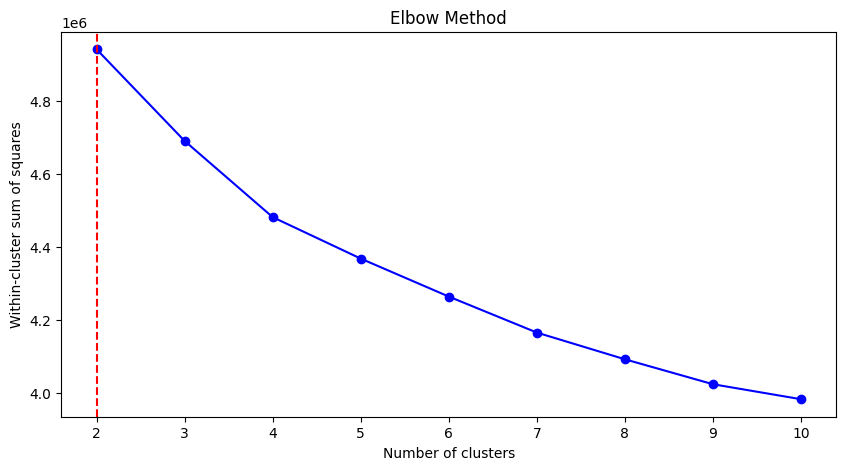

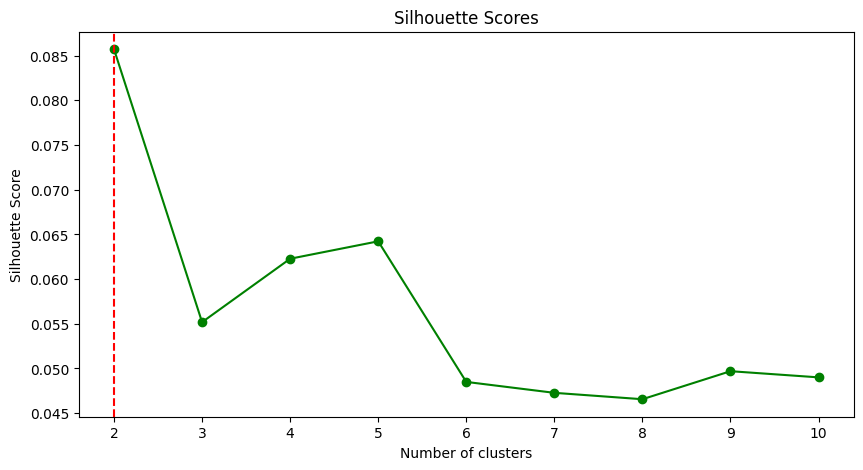

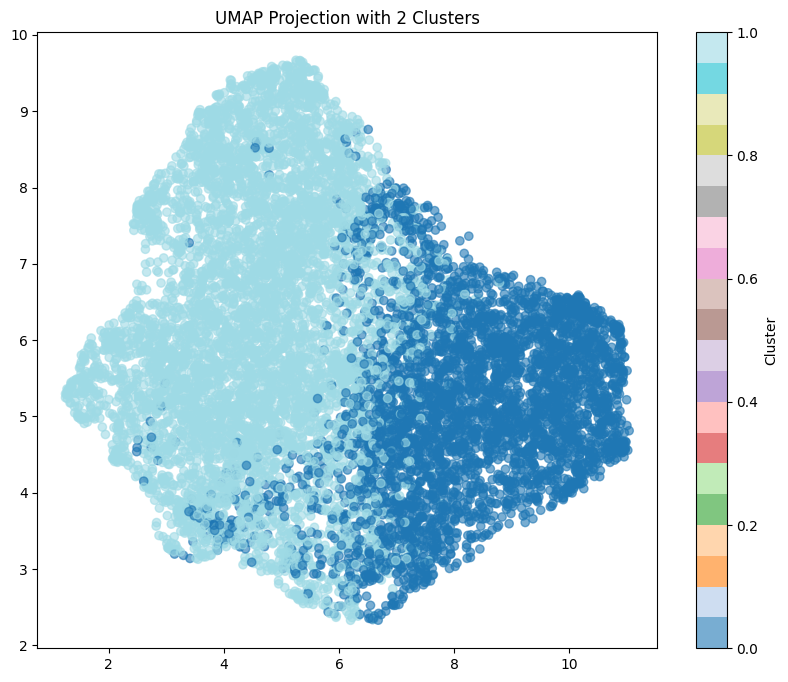

In [34]:
results = analyze_histology_patches(X_scaled)
print(f"Optimal clusters: {results['optimal_k']}")
print(f"Silhouette scores: {results['silhouette_scores']}")
# Save plots
for name, fig in results['plots'].items():
    display(fig)
    fig.savefig(f"{name}.png")
    plt.close(fig)

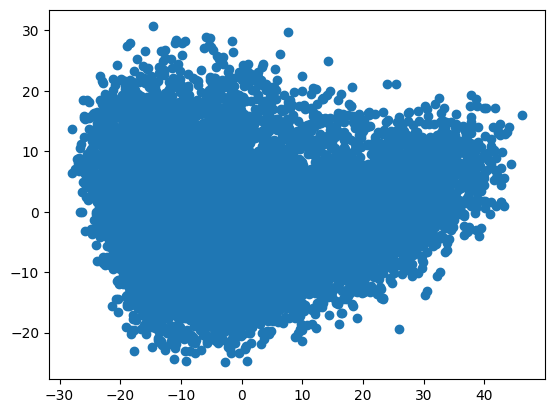

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
reduced = pca.fit_transform(X)
plt.scatter(reduced[:,0], reduced[:,1])


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

KMeans Results:


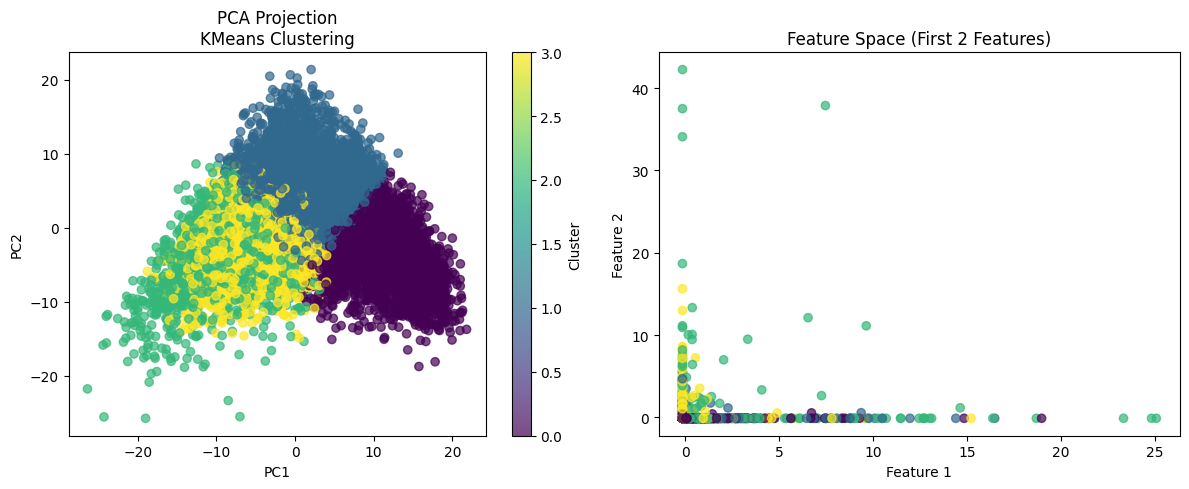

In [41]:
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Clustering methods
def cluster_and_plot(X, X_pca, n_clusters = 4):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    model = KMeans(n_clusters=n_clusters)
    labels = model.fit_predict(X)
    title = 'KMeans Clustering'

    # Plot PCA results
    scatter = ax1.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', alpha=0.7)
    ax1.set_title(f'PCA Projection\n{title}')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    
    # Plot feature space (first 2 features)
    ax2.scatter(X[:,0], X[:,1], c=labels, cmap='viridis', alpha=0.7)
    ax2.set_title('Feature Space (First 2 Features)')
    ax2.set_xlabel('Feature 1')
    ax2.set_ylabel('Feature 2')
    
    plt.colorbar(scatter, ax=ax1, label='Cluster')
    plt.tight_layout()
    plt.show()
    
    return labels

# Run all methods
n_clusters = 4
print("KMeans Results:")
kmeans_labels = cluster_and_plot(X_scaled, X_pca, n_clusters)

<Axes: >

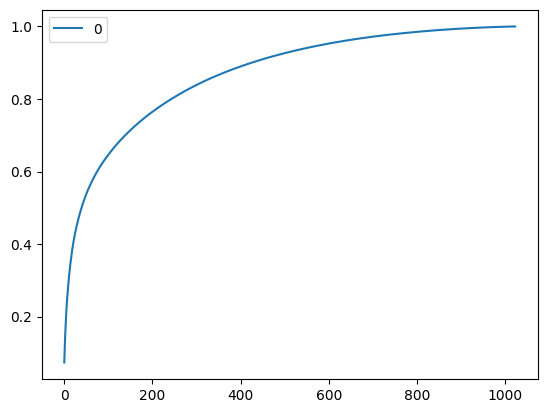

In [65]:
# Remove near-zero variance features
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)  # Keep features with >1% variance
X_filtered = selector.fit_transform(X_scaled)

# Then apply PCA
pca_full = PCA().fit(X_filtered)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
dfv=pd.DataFrame(np.array([cumulative_variance]).T)
dfv.plot()

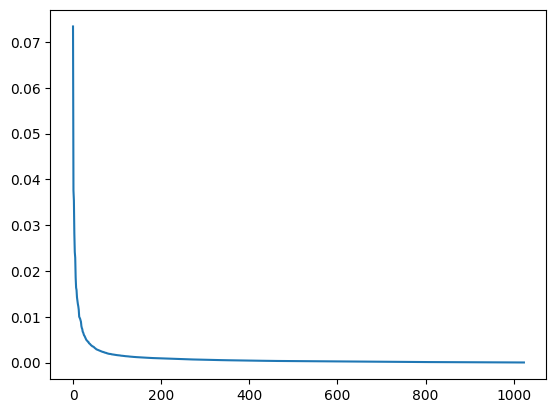

In [67]:
plt.plot(pca_full.explained_variance_ratio_)

In [ ]:
pca_full.explained_variance_ratio_.tolist()

In [47]:
from sklearn.decomposition import PCA

# Fit PCA with all components
pca_full = PCA().fit(X_scaled)  # No n_components specified

# Get cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

<Axes: >

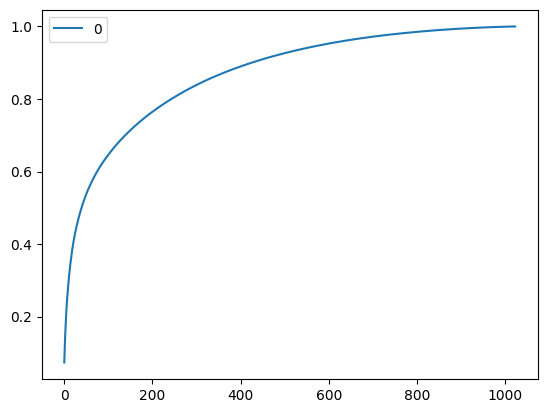

In [63]:
import pandas as pd
dfv=pd.DataFrame(np.array([cumulative_variance]).T)
dfv.plot()

In [70]:

# Find components explaining >0.5% variance
significant_components = np.where(pca_full.explained_variance_ratio_ > 0.005)[0]
print(f"Use first {len(significant_components)} components for >0.5% variance each")


Use first 30 components for >0.5% variance each


In [72]:
from kneed import KneeLocator
kneedle = KneeLocator(
    range(len(pca_full.explained_variance_ratio_)),
    pca_full.explained_variance_ratio_,
    curve='convex',
    direction='decreasing'
)
print(f"Optimal components: {kneedle.elbow}")

Optimal components: 44


Text(0.5, 1.0, "Top 50 Components' Variance Contributions")

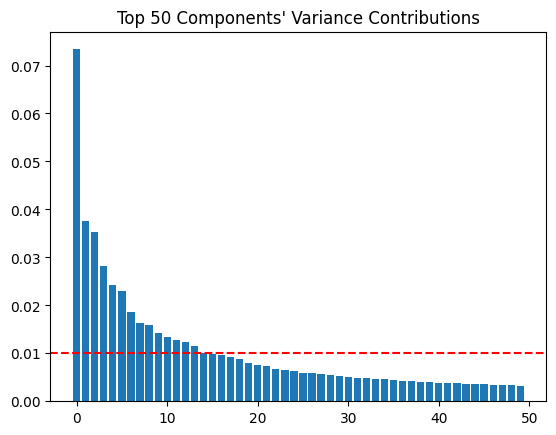

In [73]:
plt.bar(range(50), pca_full.explained_variance_ratio_[:50])
plt.axhline(y=0.01, color='r', linestyle='--')
plt.title("Top 50 Components' Variance Contributions")

In [75]:
cum_var_30 = np.sum(pca_full.explained_variance_ratio_[:30])
cum_var_44 = np.sum(pca_full.explained_variance_ratio_[:44])
print(f"30 components: {cum_var_30:.1%} variance\n44 components: {cum_var_44:.1%} variance")


30 components: 45.5% variance
44 components: 51.5% variance
